# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()



In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


In [7]:
# for col in hour_cols:
#     XTRA[col].shift(-4)
#     XTRB[col].shift(-4)
#     XTRB[col].shift(-4)

## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

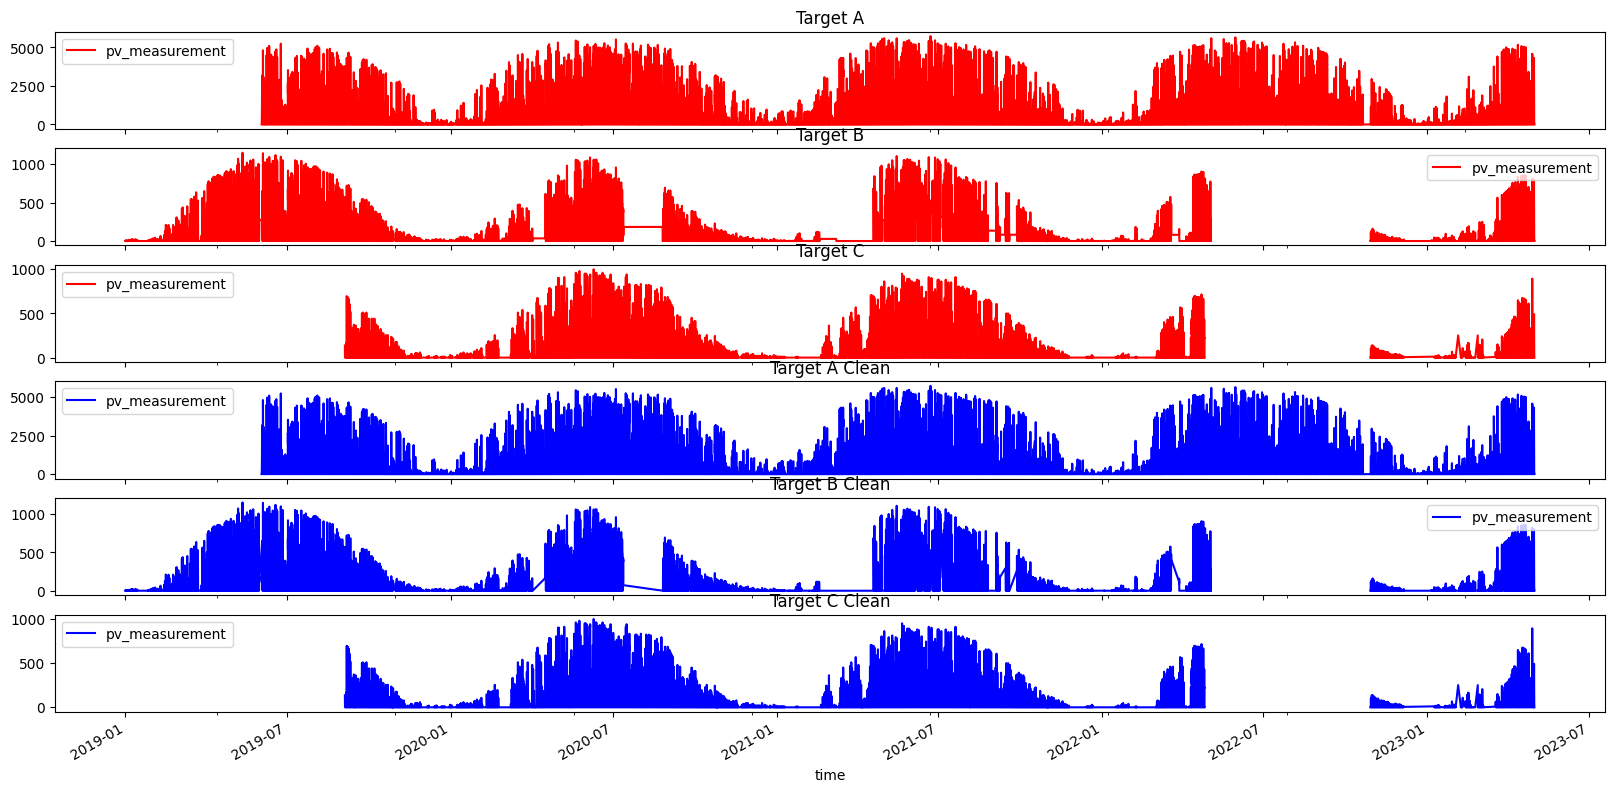

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34061 34061
x,y:  29596 29596
x,y:  26028 26028


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34056   2023-04-30 19:00:00
34057   2023-04-30 20:00:00
34058   2023-04-30 21:00:00
34059   2023-04-30 22:00:00
34060   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     #X_train[i].drop(columns=['date_forecast'], inplace=True)
     #X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)

Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_energy_1h:J']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_energy_1h:J']

    X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)

In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)

In [16]:
X_frames_test[0].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date_forecast,720,2023-06-05 21:54:00,2023-05-01 00:00:00,2023-05-23 11:45:00,2023-06-03 23:30:00,2023-06-19 11:15:00,2023-07-03 23:00:00,NaN
is_day:idx,720.0,0.773611,0.0,1.0,1.0,1.0,1.0,0.418785
is_in_shadow:idx,720.0,0.223611,0.0,0.0,0.0,0.0,1.0,0.416954
air_density_2m:kgm3,720.0,1.23315,1.151,1.209,1.238625,1.26,1.29975,0.032103
ceiling_height_agl:m,532.0,3096.332764,53.299999,953.0,1712.699951,4097.362305,11430.775391,2945.732422
...,...,...,...,...,...,...,...,...
msl_pressure:hPa_mean,720.0,1011.595459,981.224976,1006.287552,1015.284424,1018.703094,1024.243652,9.720791
diffuse_rad:W_mean,720.0,99.84201,0.0,4.534375,60.937498,171.668747,382.462494,107.507828
diffuse_rad_1h:J_mean,720.0,359430.625,0.0,22751.871094,231012.140625,594694.328125,1365011.25,382736.5625
COMB_clear_sky_energy_X_eff_cloud_cover,720.0,40757449.419796,-0.0,-0.0,2416627.26153,54637094.837217,298219150.0,67626795.937324


## Data Cleaning

In [17]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6127,4588,5122
cloud_base_agl:m,2363,2025,2199
snow_density:kgm3,32921,28040,24561


In [18]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [19]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

In [20]:
drop_cols_a = [
    "fresh_snow_12h:cm", 
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_drift:idx",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2"
]

X_train[0].drop(columns=drop_cols_a, inplace=True)
X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

# Training the model

In [21]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)

In [22]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='good_quality') #, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_091810"
Presets specified: ['good_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_091810"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   376.83 GB / 994.66 GB (37.9%)
Train Data Rows:    34061
Train Data Columns: 52
Label Col

[1000]	valid_set's l1: 158.735
[2000]	valid_set's l1: 151.43
[3000]	valid_set's l1: 147.943
[4000]	valid_set's l1: 145.606
[5000]	valid_set's l1: 144.171
[6000]	valid_set's l1: 143.632
[7000]	valid_set's l1: 143.018
[8000]	valid_set's l1: 142.532
[9000]	valid_set's l1: 142.169
[10000]	valid_set's l1: 141.93
[1000]	valid_set's l1: 160.597
[2000]	valid_set's l1: 152.333
[3000]	valid_set's l1: 149.288
[4000]	valid_set's l1: 147.402
[5000]	valid_set's l1: 146.186
[6000]	valid_set's l1: 145.33
[7000]	valid_set's l1: 144.749
[8000]	valid_set's l1: 144.27
[9000]	valid_set's l1: 143.925
[10000]	valid_set's l1: 143.631
[1000]	valid_set's l1: 158.581
[2000]	valid_set's l1: 150.597
[3000]	valid_set's l1: 146.717
[4000]	valid_set's l1: 144.812
[5000]	valid_set's l1: 143.562
[6000]	valid_set's l1: 142.406
[7000]	valid_set's l1: 141.593
[8000]	valid_set's l1: 141.1
[9000]	valid_set's l1: 140.739
[10000]	valid_set's l1: 140.441
[1000]	valid_set's l1: 156.609
[2000]	valid_set's l1: 148.806
[3000]	vali

	-143.4021	 = Validation score   (-mean_absolute_error)
	980.7s	 = Training   runtime
	3.75s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 158.318
[2000]	valid_set's l1: 154.449
[3000]	valid_set's l1: 153.316
[4000]	valid_set's l1: 152.638
[5000]	valid_set's l1: 152.453
[6000]	valid_set's l1: 152.321
[7000]	valid_set's l1: 152.199
[8000]	valid_set's l1: 152.074
[9000]	valid_set's l1: 152.01
[10000]	valid_set's l1: 151.953
[1000]	valid_set's l1: 162.135
[2000]	valid_set's l1: 158.887
[3000]	valid_set's l1: 156.829
[4000]	valid_set's l1: 155.913
[5000]	valid_set's l1: 155.551
[6000]	valid_set's l1: 155.323
[7000]	valid_set's l1: 155.187
[8000]	valid_set's l1: 155.098
[9000]	valid_set's l1: 155.051
[10000]	valid_set's l1: 155.018
[1000]	valid_set's l1: 159.22
[2000]	valid_set's l1: 155.712
[3000]	valid_set's l1: 154.491
[4000]	valid_set's l1: 153.725
[5000]	valid_set's l1: 153.337
[6000]	valid_set's l1: 153.078
[7000]	valid_set's l1: 152.875
[8000]	valid_set's l1: 152.742
[9000]	valid_set's l1: 152.688
[10000]	valid_set's l1: 152.645
[1000]	valid_set's l1: 156.979
[2000]	valid_set's l1: 153.391
[3000]	

	-154.9876	 = Validation score   (-mean_absolute_error)
	1167.75s	 = Training   runtime
	5.28s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-178.244	 = Validation score   (-mean_absolute_error)
	29.97s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-181.3778	 = Validation score   (-mean_absolute_error)
	2.89s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-178.0968	 = Validation score   (-mean_absolute_error)
	192.55s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		'Booster' object has no attribute 'best_ntree_limit'
Detailed Traceback:
Trace

[1000]	valid_set's l1: 151.392
[2000]	valid_set's l1: 149.905
[3000]	valid_set's l1: 149.49
[4000]	valid_set's l1: 149.357
[5000]	valid_set's l1: 149.312
[6000]	valid_set's l1: 149.296
[7000]	valid_set's l1: 149.288
[8000]	valid_set's l1: 149.285
[9000]	valid_set's l1: 149.283
[10000]	valid_set's l1: 149.283
[1000]	valid_set's l1: 157.317
[2000]	valid_set's l1: 155.619
[3000]	valid_set's l1: 155.227
[4000]	valid_set's l1: 155.095
[5000]	valid_set's l1: 155.052
[6000]	valid_set's l1: 155.035
[7000]	valid_set's l1: 155.028
[8000]	valid_set's l1: 155.025
[9000]	valid_set's l1: 155.024
[10000]	valid_set's l1: 155.023
[1000]	valid_set's l1: 152.685
[2000]	valid_set's l1: 151.243
[3000]	valid_set's l1: 150.881
[4000]	valid_set's l1: 150.801
[5000]	valid_set's l1: 150.761
[6000]	valid_set's l1: 150.747
[7000]	valid_set's l1: 150.74
[8000]	valid_set's l1: 150.737
[9000]	valid_set's l1: 150.736
[10000]	valid_set's l1: 150.735
[1000]	valid_set's l1: 151.678
[2000]	valid_set's l1: 150.032
[3000]	

	-152.7882	 = Validation score   (-mean_absolute_error)
	4204.95s	 = Training   runtime
	10.53s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-141.4267	 = Validation score   (-mean_absolute_error)
	0.19s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-144.5744	 = Validation score   (-mean_absolute_error)
	44.0s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-141.9558	 = Validation score   (-mean_absolute_error)
	19.28s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-140.4239	 = Validation score   (-mean_absolute_error)
	31.91s	 = Training   runtime
	0.74s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8)

In [23]:
y_a_test = predictor.predict(x_val_a)

In [24]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1_FULL,-0.052742,NaN,2.013805,NaN,183.641034,2.013805,NaN,183.641034,1,True,23
1,LightGBM_BAG_L1_FULL,-4.134467,NaN,0.705554,NaN,40.876503,0.705554,NaN,40.876503,1,True,18
2,LightGBMXT_BAG_L1_FULL,-24.456726,NaN,0.675584,NaN,73.394088,0.675584,NaN,73.394088,1,True,17
3,ExtraTreesMSE_BAG_L2_FULL,-27.823756,NaN,3.823157,NaN,387.059074,0.168328,0.807595,3.590231,2,True,28
4,LightGBM_BAG_L2_FULL,-31.742562,NaN,3.665566,NaN,384.679657,0.010737,NaN,1.210814,2,True,26
5,RandomForestMSE_BAG_L2_FULL,-32.728178,NaN,3.783247,NaN,415.375021,0.128418,0.741688,31.906178,2,True,27
6,LightGBMLarge_BAG_L2_FULL,-34.694834,NaN,3.682470,NaN,388.110475,0.027641,NaN,4.641632,2,True,31
7,WeightedEnsemble_L2_FULL,-37.852545,NaN,2.712997,NaN,291.667496,0.002346,NaN,0.191064,2,True,24
8,WeightedEnsemble_L3_FULL,-39.712812,NaN,4.044550,NaN,450.794598,0.002396,NaN,0.281324,3,True,32
9,LightGBMXT_BAG_L2_FULL,-40.611503,NaN,3.677201,NaN,386.150513,0.022372,NaN,2.681670,2,True,25


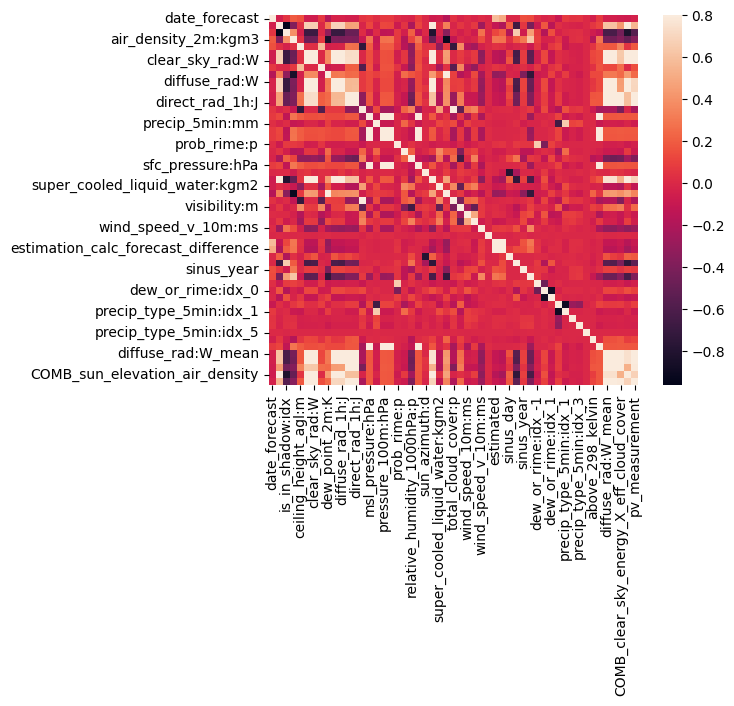

In [25]:
import seaborn as sb
cm = joined_a.corr()
fig = plt.figure()
sb.heatmap(cm, vmax=0.8, square=True)
plt.show()

In [26]:
joined_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
train_b = TabularDataset(joined_b)
predictor_b = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_b, presets='good_quality')#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_113045"
Presets specified: ['good_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_113045"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   375.10 GB / 994.66 GB (37.7%)
Train Data Rows:    29596
Train Data Columns: 61
Label Col

[1000]	valid_set's l1: 19.7314
[2000]	valid_set's l1: 18.8513
[3000]	valid_set's l1: 18.5046
[4000]	valid_set's l1: 18.2489
[5000]	valid_set's l1: 18.0846
[6000]	valid_set's l1: 18.0024
[7000]	valid_set's l1: 17.9241
[8000]	valid_set's l1: 17.8877
[9000]	valid_set's l1: 17.8376
[10000]	valid_set's l1: 17.8157
[1000]	valid_set's l1: 21.1825
[2000]	valid_set's l1: 20.0594
[3000]	valid_set's l1: 19.5983
[4000]	valid_set's l1: 19.3141
[5000]	valid_set's l1: 19.1673
[6000]	valid_set's l1: 19.0662
[7000]	valid_set's l1: 18.9898
[8000]	valid_set's l1: 18.9317
[9000]	valid_set's l1: 18.902
[10000]	valid_set's l1: 18.8786
[1000]	valid_set's l1: 21.0302
[2000]	valid_set's l1: 19.8868
[3000]	valid_set's l1: 19.3654
[4000]	valid_set's l1: 19.1103
[5000]	valid_set's l1: 18.9337
[6000]	valid_set's l1: 18.8278
[7000]	valid_set's l1: 18.7382
[8000]	valid_set's l1: 18.6863
[9000]	valid_set's l1: 18.6322
[10000]	valid_set's l1: 18.5896
[1000]	valid_set's l1: 19.821
[2000]	valid_set's l1: 18.8788
[3000]	

	-18.3701	 = Validation score   (-mean_absolute_error)
	982.1s	 = Training   runtime
	3.34s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.6831
[2000]	valid_set's l1: 19.2469
[3000]	valid_set's l1: 19.099
[4000]	valid_set's l1: 19.0233
[5000]	valid_set's l1: 18.9893
[6000]	valid_set's l1: 18.9685
[7000]	valid_set's l1: 18.9539
[8000]	valid_set's l1: 18.951
[9000]	valid_set's l1: 18.9449
[10000]	valid_set's l1: 18.9414
[1000]	valid_set's l1: 21.5939
[2000]	valid_set's l1: 21.1903
[3000]	valid_set's l1: 21.011
[4000]	valid_set's l1: 20.9596
[5000]	valid_set's l1: 20.9247
[6000]	valid_set's l1: 20.909
[7000]	valid_set's l1: 20.8982
[8000]	valid_set's l1: 20.8872
[9000]	valid_set's l1: 20.884
[10000]	valid_set's l1: 20.8819
[1000]	valid_set's l1: 21.1685
[2000]	valid_set's l1: 20.713
[3000]	valid_set's l1: 20.5454
[4000]	valid_set's l1: 20.4719
[5000]	valid_set's l1: 20.4351
[6000]	valid_set's l1: 20.4038
[7000]	valid_set's l1: 20.3918
[8000]	valid_set's l1: 20.3807
[9000]	valid_set's l1: 20.3771
[10000]	valid_set's l1: 20.3731
[1000]	valid_set's l1: 19.8601
[2000]	valid_set's l1: 19.4216
[3000]	vali

	-19.9508	 = Validation score   (-mean_absolute_error)
	1033.9s	 = Training   runtime
	4.0s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-23.3717	 = Validation score   (-mean_absolute_error)
	20.1s	 = Training   runtime
	0.53s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-23.9538	 = Validation score   (-mean_absolute_error)
	2.85s	 = Training   runtime
	0.59s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-22.6169	 = Validation score   (-mean_absolute_error)
	116.37s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		'Booster' object has no attribute 'best_ntree_limit'
Detailed Traceback:
Traceback 

[1000]	valid_set's l1: 18.8237
[2000]	valid_set's l1: 18.6951
[3000]	valid_set's l1: 18.6726
[4000]	valid_set's l1: 18.6643
[5000]	valid_set's l1: 18.6614
[6000]	valid_set's l1: 18.6607
[7000]	valid_set's l1: 18.6604
[8000]	valid_set's l1: 18.6602
[9000]	valid_set's l1: 18.6601
[10000]	valid_set's l1: 18.6601
[1000]	valid_set's l1: 20.362
[2000]	valid_set's l1: 20.1946
[3000]	valid_set's l1: 20.1586
[4000]	valid_set's l1: 20.1499
[5000]	valid_set's l1: 20.1472
[6000]	valid_set's l1: 20.1464
[7000]	valid_set's l1: 20.1461
[8000]	valid_set's l1: 20.1459
[9000]	valid_set's l1: 20.1459
[10000]	valid_set's l1: 20.1459
[1000]	valid_set's l1: 20.721
[2000]	valid_set's l1: 20.5487
[3000]	valid_set's l1: 20.5147
[4000]	valid_set's l1: 20.5056
[5000]	valid_set's l1: 20.5027
[6000]	valid_set's l1: 20.5018
[7000]	valid_set's l1: 20.5016
[8000]	valid_set's l1: 20.5015
[9000]	valid_set's l1: 20.5015
[10000]	valid_set's l1: 20.5015
[1000]	valid_set's l1: 19.0215
[2000]	valid_set's l1: 18.8322
[3000]	

	-19.8229	 = Validation score   (-mean_absolute_error)
	3521.99s	 = Training   runtime
	10.84s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-18.002	 = Validation score   (-mean_absolute_error)
	0.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-18.6134	 = Validation score   (-mean_absolute_error)
	51.7s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-18.3385	 = Validation score   (-mean_absolute_error)
	27.08s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-17.7645	 = Validation score   (-mean_absolute_error)
	30.57s	 = Training   runtime
	0.54s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fit

In [27]:
y_b_test = predictor_b.predict(x_val_b)

In [28]:
join_val_b = pd.merge(x_val_b, y_val_b, left_index=True, right_index=True)
predictor_b.leaderboard(join_val_b, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1_FULL,-0.003056,NaN,2.134792,NaN,193.268606,2.134792,NaN,193.268606,1,True,23
1,LightGBM_BAG_L1_FULL,-0.339794,NaN,0.824050,NaN,49.197199,0.824050,NaN,49.197199,1,True,18
2,LightGBMXT_BAG_L1_FULL,-2.403679,NaN,0.656987,NaN,93.392490,0.656987,NaN,93.392490,1,True,17
3,ExtraTreesMSE_BAG_L2_FULL,-4.211646,NaN,4.042646,NaN,412.806146,0.094525,0.569212,2.721117,2,True,28
4,WeightedEnsemble_L3_FULL,-4.515283,NaN,4.205002,NaN,475.454331,0.002572,NaN,0.259692,3,True,32
5,WeightedEnsemble_L2_FULL,-4.558609,NaN,3.656060,NaN,372.126358,0.001694,NaN,0.173365,2,True,24
6,RandomForestMSE_BAG_L2_FULL,-4.651452,NaN,4.041206,NaN,440.650476,0.093085,0.540014,30.565446,2,True,27
7,LightGBM_BAG_L2_FULL,-4.811313,NaN,3.962698,NaN,411.052717,0.014577,NaN,0.967688,2,True,26
8,NeuralNetFastAI_BAG_L2_FULL,-4.913921,NaN,3.983524,NaN,426.289293,0.035403,NaN,16.204263,2,True,29
9,LightGBMLarge_BAG_L2_FULL,-5.526944,NaN,3.974747,NaN,415.826555,0.026626,NaN,5.741526,2,True,31


In [29]:
joined_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='good_quality')#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_132825"
Presets specified: ['good_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_132825"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   373.68 GB / 994.66 GB (37.6%)
Train Data Rows:    26028
Train Data Columns: 61
Label Col

[1000]	valid_set's l1: 16.6868
[2000]	valid_set's l1: 16.0725
[3000]	valid_set's l1: 15.7372
[4000]	valid_set's l1: 15.6128
[5000]	valid_set's l1: 15.522
[6000]	valid_set's l1: 15.4529
[7000]	valid_set's l1: 15.4151
[8000]	valid_set's l1: 15.3895
[9000]	valid_set's l1: 15.3666
[10000]	valid_set's l1: 15.3493
[1000]	valid_set's l1: 17.0393
[2000]	valid_set's l1: 16.3382
[3000]	valid_set's l1: 16.0488
[4000]	valid_set's l1: 15.8783
[5000]	valid_set's l1: 15.7591
[6000]	valid_set's l1: 15.677
[7000]	valid_set's l1: 15.6193
[8000]	valid_set's l1: 15.5894
[9000]	valid_set's l1: 15.5678
[10000]	valid_set's l1: 15.5432
[1000]	valid_set's l1: 16.8835
[2000]	valid_set's l1: 15.861
[3000]	valid_set's l1: 15.3987
[4000]	valid_set's l1: 15.1682
[5000]	valid_set's l1: 15.0261
[6000]	valid_set's l1: 14.9339
[7000]	valid_set's l1: 14.8757
[8000]	valid_set's l1: 14.8339
[9000]	valid_set's l1: 14.8022
[10000]	valid_set's l1: 14.7825
[1000]	valid_set's l1: 16.6774
[2000]	valid_set's l1: 15.9846
[3000]	v

	-15.3242	 = Validation score   (-mean_absolute_error)
	988.4s	 = Training   runtime
	3.09s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 17.1593
[2000]	valid_set's l1: 16.8023
[3000]	valid_set's l1: 16.676
[4000]	valid_set's l1: 16.6272
[5000]	valid_set's l1: 16.5971
[6000]	valid_set's l1: 16.5784
[7000]	valid_set's l1: 16.5673
[8000]	valid_set's l1: 16.5626
[9000]	valid_set's l1: 16.5598
[10000]	valid_set's l1: 16.5576
[1000]	valid_set's l1: 17.0223
[2000]	valid_set's l1: 16.7054
[3000]	valid_set's l1: 16.6082
[4000]	valid_set's l1: 16.5457
[5000]	valid_set's l1: 16.5203
[6000]	valid_set's l1: 16.4974
[7000]	valid_set's l1: 16.4857
[8000]	valid_set's l1: 16.479
[9000]	valid_set's l1: 16.4739
[10000]	valid_set's l1: 16.4705
[1000]	valid_set's l1: 17.3571
[2000]	valid_set's l1: 16.9173
[3000]	valid_set's l1: 16.7677
[4000]	valid_set's l1: 16.7178
[5000]	valid_set's l1: 16.6946
[6000]	valid_set's l1: 16.6752
[7000]	valid_set's l1: 16.6665
[8000]	valid_set's l1: 16.6593
[9000]	valid_set's l1: 16.6556
[10000]	valid_set's l1: 16.6522
[1000]	valid_set's l1: 17.1399
[2000]	valid_set's l1: 16.8089
[3000]	

	-16.7922	 = Validation score   (-mean_absolute_error)
	4984.32s	 = Training   runtime
	3.78s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-19.2877	 = Validation score   (-mean_absolute_error)
	16.76s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-19.439	 = Validation score   (-mean_absolute_error)
	2.17s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-18.6881	 = Validation score   (-mean_absolute_error)
	94.75s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		'Booster' object has no attribute 'best_ntree_limit'
Detailed Traceback:
Traceback

[1000]	valid_set's l1: 16.5707
[2000]	valid_set's l1: 16.4725
[3000]	valid_set's l1: 16.4523
[4000]	valid_set's l1: 16.449
[5000]	valid_set's l1: 16.4481
[6000]	valid_set's l1: 16.4478
[7000]	valid_set's l1: 16.4476
[8000]	valid_set's l1: 16.4476
[9000]	valid_set's l1: 16.4476
[10000]	valid_set's l1: 16.4475
[1000]	valid_set's l1: 16.642
[2000]	valid_set's l1: 16.5287
[3000]	valid_set's l1: 16.5108
[4000]	valid_set's l1: 16.5073
[5000]	valid_set's l1: 16.5063
[6000]	valid_set's l1: 16.5059
[7000]	valid_set's l1: 16.5057
[8000]	valid_set's l1: 16.5057
[9000]	valid_set's l1: 16.5056
[10000]	valid_set's l1: 16.5056
[1000]	valid_set's l1: 16.5191
[2000]	valid_set's l1: 16.3822
[3000]	valid_set's l1: 16.3621
[4000]	valid_set's l1: 16.3569
[5000]	valid_set's l1: 16.3551
[6000]	valid_set's l1: 16.3545
[7000]	valid_set's l1: 16.3543
[8000]	valid_set's l1: 16.3542
[9000]	valid_set's l1: 16.3542
[10000]	valid_set's l1: 16.3542
[1000]	valid_set's l1: 16.3143
[2000]	valid_set's l1: 16.2293
[3000]	

	-16.6904	 = Validation score   (-mean_absolute_error)
	2840.36s	 = Training   runtime
	8.83s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-15.0717	 = Validation score   (-mean_absolute_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.7377	 = Validation score   (-mean_absolute_error)
	51.86s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.4088	 = Validation score   (-mean_absolute_error)
	21.75s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-14.96	 = Validation score   (-mean_absolute_error)
	21.29s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitti

In [30]:
y_c_test = predictor_c.predict(x_val_c)

In [31]:
join_val_c = pd.merge(x_val_c, y_val_c, left_index=True, right_index=True)
predictor_c.leaderboard(join_val_c, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1_FULL,-0.001358,NaN,1.670651,NaN,172.864605,1.670651,NaN,172.864605,1,True,23
1,LightGBM_BAG_L1_FULL,-0.224897,NaN,0.705641,NaN,44.987205,0.705641,NaN,44.987205,1,True,18
2,LightGBMXT_BAG_L1_FULL,-1.698416,NaN,0.545999,NaN,67.709182,0.545999,NaN,67.709182,1,True,17
3,ExtraTreesMSE_BAG_L2_FULL,-3.381558,NaN,3.221775,NaN,346.378314,0.070862,0.491518,2.337867,2,True,28
4,WeightedEnsemble_L3_FULL,-3.508788,NaN,3.362175,NaN,389.484264,0.001154,NaN,0.247218,3,True,32
5,WeightedEnsemble_L2_FULL,-3.738250,NaN,2.238930,NaN,266.909629,0.001598,NaN,0.163724,2,True,24
6,RandomForestMSE_BAG_L2_FULL,-3.937127,NaN,3.233589,NaN,365.331292,0.082676,0.457194,21.290845,2,True,27
7,LightGBM_BAG_L2_FULL,-3.982061,NaN,3.160798,NaN,344.907457,0.009885,NaN,0.867010,2,True,26
8,LightGBMLarge_BAG_L2_FULL,-4.585215,NaN,3.171286,NaN,349.142141,0.020373,NaN,5.101693,2,True,31
9,NeuralNetFastAI_BAG_L2_FULL,-4.639025,NaN,3.178555,NaN,356.155426,0.027643,NaN,12.114978,2,True,29


## Evaluate

In [32]:
from sklearn.metrics import mean_absolute_error
mae_a = mean_absolute_error(y_val_a, predictor.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_b_test)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_c_test)
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

MAE for A:  39.71281235255244
MAE for B:  4.515283458629612
MAE for C:  3.5087877130134695
Mean MAE:  15.912294508065173


In [33]:
# x_val_a

In [34]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)

In [35]:
pred = predictor.predict(X_train[0][34000:34025])

In [36]:
goal = Y_train[0][34000:34025]

In [37]:
g=34000
print(pred[34000])
for i in range(len(pred)):
    print(i, pred[i+g]-goal[i+g], pred[i+g], goal[i+g])

855.8206
0 -221.29938232421864 855.8206 1077.12
1 18.91958007812491 1486.3196 1467.4
2 -460.65625 4120.8438 4581.5
3 82.97738769531247 1221.6974 1138.72
4 -21.481171874999973 1281.7988 1303.28
5 38.22955078124983 1280.7896 1242.5600000000002
6 -30.913232421875023 778.68677 809.6
7 -25.267296142578118 278.5527 303.82
8 12.280349731445312 34.28035 22.0
9 17.357450485229492 17.35745 0.0
10 17.72382354736328 17.723824 0.0
11 17.690614700317383 17.690615 0.0
12 17.777938842773438 17.777939 0.0
13 17.626474380493164 17.626474 0.0
14 17.462055206298828 17.462055 0.0
15 16.612483978271484 16.612484 0.0
16 0.07876983642578494 43.41877 43.339999999999996
17 -18.932384033203107 138.58762 157.51999999999998
18 -46.456573486328125 256.04343 302.5
19 64.49330810546877 387.4533 322.96
20 -7.683834228515593 471.47617 479.15999999999997
21 28.764296875000014 674.9043 646.14
22 -7.923549804687468 894.73645 902.66
23 3.1628320312497635 1084.9028 1081.7400000000002
24 -10.7020117187501 1333.938 1344.64


In [38]:
print(goal[11+g], pred[11+g])

0.0 17.690615


In [39]:
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

In [40]:
test_pred = predictor.transform_features(X_frames_test[0][0:25])

In [41]:
predictor.predict(test_pred)

34061      15.502867
34062      15.256422
34063      15.356131
34064      50.681835
34065     319.611176
34066     802.164185
34067    1696.282227
34068    3184.991455
34069    3134.169922
34070    2983.193604
34071    3639.419189
34072    3296.922852
34073    2649.825684
34074    3057.472656
34075    2572.803223
34076    1595.059082
34077    1414.158569
34078     600.350220
34079     201.429108
34080      38.868683
34081      17.521238
34082      18.215988
34083      17.210369
34084      17.085529
34085      14.099195
Name: pv_measurement, dtype: float32

In [42]:
X_train[0].tail(25)

,date_forecast,is_day:idx,is_in_shadow:idx,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_energy_X_eff_cloud_cover,COMB_sun_elevation_air_density
34036,2023-04-29 23:00:00,0,1,1.27725,4197.399902,0.000000e+00,0.000000,750.224976,271.950012,0.000000,...,0,0,0,0,0,1005.168762,0.000000,0.000000,0.000000e+00,-0.268880
34037,2023-04-30 00:00:00,0,1,1.28100,2507.550049,0.000000e+00,0.000000,1075.074951,271.700012,0.000000,...,0,0,0,0,0,1006.143738,0.000000,0.000000,-0.000000e+00,-0.241106
34038,2023-04-30 01:00:00,0,1,1.27850,2224.600098,0.000000e+00,0.000000,949.799988,271.650024,0.000000,...,0,0,0,0,0,1005.862549,0.000000,0.000000,0.000000e+00,-0.182351
34039,2023-04-30 02:00:00,0,1,1.27700,2318.500000,0.000000e+00,0.000000,1700.574951,271.600006,0.000000,...,0,0,0,0,0,1005.606201,0.000000,0.000000,0.000000e+00,-0.091647
34040,2023-04-30 03:00:00,1,0,1.27600,3395.800049,8.052975e+03,9.950000,2417.175049,271.500000,8.025000,...,0,0,0,0,0,1005.299988,4.950000,8901.988281,3.746647e+05,0.024902
34041,2023-04-30 04:00:00,1,0,1.27350,2289.975098,1.307704e+05,72.675003,932.099976,271.399994,43.875000,...,0,0,0,0,0,1004.962463,30.100000,63076.222656,3.602724e+06,0.159154
34042,2023-04-30 05:00:00,1,0,1.26950,4014.899902,4.540071e+05,185.199997,919.950012,271.575012,97.324997,...,0,1,0,0,0,1004.612549,63.837498,169100.500000,2.383544e+05,0.301333
34043,2023-04-30 06:00:00,1,0,1.26700,2650.449951,9.014685e+05,316.549988,1157.025024,272.000000,140.500000,...,0,1,0,0,0,1004.443787,80.599998,260012.781250,4.507342e+06,0.442149
34044,2023-04-30 07:00:00,1,0,1.26550,1734.449951,1.374201e+06,445.125000,1026.599976,272.750000,198.100006,...,0,1,0,0,0,1004.731262,135.950012,389823.968750,1.621557e+07,0.572187
34045,2023-04-30 08:00:00,1,0,1.26475,2351.500000,1.810678e+06,557.125000,732.599976,273.325012,228.074997,...,0,1,0,0,0,1005.337463,194.524994,594866.000000,1.104513e+07,0.682670


In [43]:
X_frames_test[0].head(25)

,date_forecast,is_day:idx,is_in_shadow:idx,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_energy_X_eff_cloud_cover,COMB_sun_elevation_air_density
34061,2023-05-01 00:00:00,0,1,1.28675,912.700012,0.000000e+00,0.000000,1061.550049,271.650024,0.000000,...,0,0.0,0.0,0.0,0,1008.531250,0.000000,0.000000,0.000000e+00,-0.235397
34062,2023-05-01 01:00:00,0,1,1.28600,1482.099976,0.000000e+00,0.000000,1075.100098,271.450012,0.000000,...,0,0.0,0.0,0.0,0,1008.025024,0.000000,0.000000,0.000000e+00,-0.176631
34063,2023-05-01 02:00:00,0,1,1.28375,1791.300049,0.000000e+00,0.000000,1200.400024,271.049988,0.000000,...,0,0.0,0.0,0.0,0,1007.506287,0.000000,0.000000,0.000000e+00,-0.085426
34064,2023-05-01 03:00:00,1,0,1.28200,2312.875000,1.012442e+04,11.675000,1179.849976,270.649994,9.375000,...,0,0.0,0.0,0.0,0,1006.974976,5.737500,10305.288086,3.179070e+05,0.031602
34065,2023-05-01 04:00:00,1,0,1.28100,2198.299805,1.417486e+05,76.875000,920.049988,270.375000,47.400002,...,0,0.0,0.0,0.0,0,1006.518738,36.425003,75890.453125,4.776927e+06,0.166506
34066,2023-05-01 05:00:00,1,0,1.27600,1957.625000,4.716072e+05,190.574997,1419.300049,270.549988,86.425003,...,0,0.0,0.0,0.0,0,1006.106201,87.325005,222806.765625,1.222642e+07,0.309076
34067,2023-05-01 06:00:00,1,0,1.26825,1903.300049,9.212486e+05,322.149994,1299.400024,270.824982,111.074997,...,0,0.0,0.0,0.0,0,1005.718750,146.287506,420540.500000,3.818575e+07,0.448538
34068,2023-05-01 07:00:00,1,0,1.26250,20000.000000,1.394139e+06,450.575012,743.299988,270.899994,130.100006,...,0,0.0,0.0,0.0,0,1005.412476,198.425003,620502.375000,7.172847e+07,0.576532
34069,2023-05-01 08:00:00,1,0,1.25975,1381.199829,1.830129e+06,562.450012,805.375000,271.024994,159.225006,...,0,0.0,0.0,0.0,0,1005.137512,237.212509,784185.750000,7.123778e+07,0.685459
34070,2023-05-01 09:00:00,1,0,1.25850,1429.824951,2.187716e+06,647.900024,884.950012,271.049988,187.600006,...,0,0.0,0.0,0.0,0,1004.956238,260.987488,896780.687500,4.348087e+07,0.767776


In [44]:
#predictions before full training
pred_split_a = predictor.predict(X_frames_test[0])
pred_split_b = predictor_b.predict(X_frames_test[1])
pred_split_c = predictor_c.predict(X_frames_test[2])

# Make predictions

In [45]:
# Do some more stuff
y_pred = np.concatenate((pred_split_a, pred_split_b, pred_split_c), axis=0)

print(len(y_pred))

2160


In [46]:
y_pred[0:10]

array([  15.502867,   15.256422,   15.356131,   50.68184 ,  319.61115 ,
        802.1642  , 1696.2822  , 3184.9915  , 3134.17    , 2983.1934  ],
      dtype=float32)

In [49]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0

# Evaluate prediction

# Create submission

In [50]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_good_1_full_submission.csv', index=False)

In [ ]:
combine = combined
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_ag_xg_2.csv", index = False)